# NEI Solver
Using the ionization and recombination rates calculated with fiasco, test methods for solving the nonequilibrium ionization equations.

In [1]:
import os
import sys

import numpy as np
import scipy.interpolate
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn.apionly as sns
import astropy.units as u
import hissw
import fiasco

sys.path.append('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/rsp_toolkit/python/')
from xml_io import InputHandler,OutputHandler

%matplotlib inline

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [11]:
with open('/Users/willbarnes/Documents/work/codes/apolloDB/balances/ips_01dex/fe.bal','r') as f:
    lines = f.readlines()
ioneq_ips = np.zeros((len(lines),len(lines[0].split())-1),dtype=np.float64)
temperature_grid_ips = np.zeros((len(lines),),dtype=np.float64)
for i,line in enumerate(lines):
    line = line.split()
    temperature_grid_ips[i] = line[0]
    ioneq_ips[i,:] = line[1:]

## Test Data

In [109]:
time = np.linspace(0,50,10000)
timescale_T = 5
timescale_n = 25
T_max,T_min = 5e7,1e7
n_max,n_min = 1e10,1e8
temperature = np.where(time>2*timescale_T,T_min,
             np.where(time<timescale_T,time*(T_max-T_min)/timescale_T+T_min,(timescale_T-time)*(T_max-T_min)/timescale_T+T_max))
density = np.where(time>2*timescale_n,n_min,
             np.where(time<timescale_n,time*(n_max-n_min)/timescale_n+n_min,(timescale_n-time)*(n_max-n_min)/timescale_n+n_max))

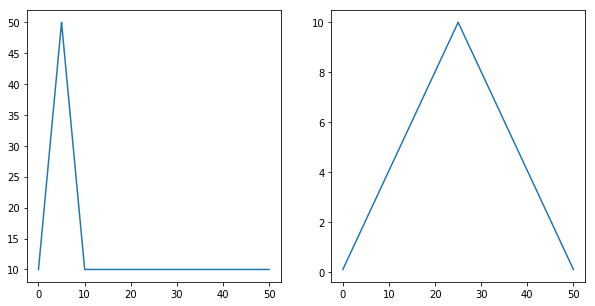

In [110]:
plt.figure(figsize=(10,5))
plt.subplot(121).plot(time,temperature/1e6)
plt.subplot(122).plot(time,density/1e9)

## IonPopSolver Simulation

In [111]:
np.savetxt('simple_test.ips.input',np.vstack([time,temperature,density]).T,
           header='{}'.format(time.shape[0]),comments='',fmt='%f\t%e\t%e')

In [112]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run -Z 26 -f 1 -t 27 \
-I simple_test.ips.input \
-O simple_test.ips.output \
-r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

0%|         |100%
  |||||||||||

The process took 22.000000 seconds to run.


In [113]:
tmp = np.loadtxt('simple_test.ips.output')
time_ips = tmp[:,0]
y_ips = tmp[:,4:]

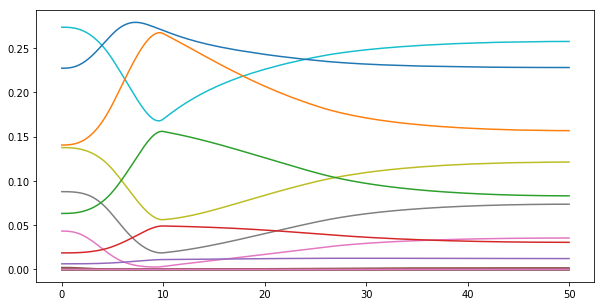

In [114]:
plt.figure(figsize=(10,5))
plt.plot(time_ips,y_ips);

## Solvers
We want to solve the ionization and recombination equations which can be written as,

$$
\frac{dY_i}{dt} = n(I_{i-1}Y_{i-1} + R_{i+1}Y_{i+1} - Y_i(R_i + I_i))
$$

such that we have $Z+1$ coupled differential equations. In matrix form, this can be written as,

$$
\frac{d}{dt}\mathbf{Y} = n\mathbf{A}\mathbf{Y}
$$

where $\mathbf{Y}\in\mathbb{R}^{Z+1}$, $\mathbf{A}\in\mathbb{R}^{Z+1\times Z+1}$.

### Implicit Solver
For a "corrector-predictor" update rule of the form,

$$
\mathbf{Y}_{n+1} = \mathbf{Y}_n + \frac{h}{2}\left(\dot{\mathbf{Y}}_{n} + \dot{\mathbf{Y}}_{n+1}\right),
$$
the update for $Y$ becomes,

$$
\mathbf{Y}_{n+1} = \left(\mathbb{1} - \frac{h}{2}n_{n+1}\mathbf{A}_{n+1}\right)^{-1}\left(\mathbb{1} + \frac{h}{2}n_n\mathbf{A_n}\right)\mathbf{Y}_n
$$

In [115]:
def nei_implicit(time,temperature,density,element,temperature_grid):
    # Atomic Data
    el = fiasco.Element(element,temperature_grid)
    ioneq = el.ionization_equilibrium()
    a_matrix = np.zeros(temperature_grid.shape+(el.atomic_number+1,el.atomic_number+1))
    for i in range(1,el.atomic_number):
        a_matrix[:,i,i] = -(el[i].ionization_rate() + el[i].recombination_rate()).value
        a_matrix[:,i,i-1] = el[i-1].ionization_rate().value
        a_matrix[:,i,i+1] = el[i+1].recombination_rate().value
    a_matrix[:,0,0] = -(el[0].ionization_rate() + el[0].recombination_rate()).value
    a_matrix[:,0,1] = el[1].recombination_rate().value
    a_matrix[:,-1,-1] = -(el[-1].ionization_rate() + el[-1].recombination_rate()).value
    a_matrix[:,-1,-2] = el[-2].ionization_rate().value
    # Interpolation and allocation
    interp_indices = [np.abs(temperature_grid.value - temp).argmin() for temp in temperature]
    interp_index_ips = np.abs(10.**(temperature_grid_ips) - temperature[0]).argmin()
    y = np.zeros(time.shape+(el.atomic_number+1,))
    y[0,:] = ioneq_ips[interp_index_ips,:]#ioneq[interp_indices[0],:]
    # Solve
    for i in range(1,time.shape[0]):
        dt = time[i] - time[i-1]
        term1 = np.eye(el.atomic_number+1) - density[i]*dt/2.*a_matrix[interp_indices[i],:,:]
        term2 = np.eye(el.atomic_number+1) + density[i-1]*dt/2.*a_matrix[interp_indices[i-1],:,:]
        y[i,:] = np.linalg.inv(term1) @ term2 @ y[i-1,:]
        y[i,:] /= y[i,:].sum()
        
    return y

In [116]:
temperature_grid = 10.**(np.arange(3.5,8.5,0.001))*u.K
y_implicit = nei_implicit(time,temperature,density,'Fe',temperature_grid)

(0, 0.4)

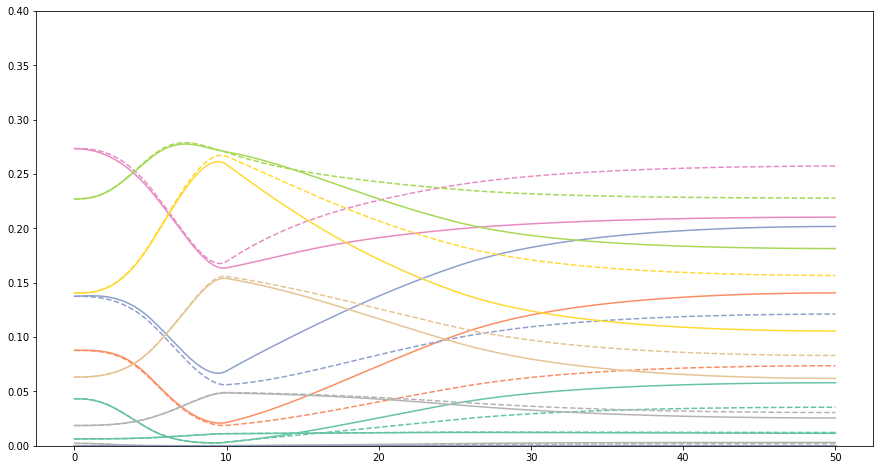

In [119]:
plt.figure(figsize=(15,8))
colors = sns.color_palette('Set2',n_colors=y_implicit.shape[1])
for i in range(y_implicit.shape[1]):
    plt.plot(time,y_implicit[:,i],ls='-',color=colors[i])
    plt.plot(time_ips,y_ips[:,i],ls='--',color=colors[i])
#plt.xscale('log')
#plt.xlim([10,50])
plt.ylim([0,0.4])
#plt.yscale('log')

### Eigenvalue Solver
An alternative solution (explored by Shen et al., 2015) is to diagonalize $\mathbf{A}$ and solve $Z+1$ individual differential equations. Recall that $\mathbf{A}$ can be written as,

$$
\mathbf{A} = \mathbf{V}\Lambda\mathbf{V}^{-1}
$$

where diagonal entries of $\Lambda$ are the eigenvalues of $\mathbf{A}$ and the columns of $\mathbf{V}$ are the eigenvectors of $\mathbf{A}$. Thus, our differential equation can be written as,

$$
\begin{align}
\frac{d}{dt}\mathbf{Y} &= n\mathbf{V}\Lambda\mathbf{V}^{-1}\mathbf{Y} \\
\mathbf{V}^{-1}\frac{d}{dt}\mathbf{Y} &= \mathbf{V}^{-1}n\mathbf{V}\Lambda\mathbf{V}^{-1}\mathbf{Y} \\
\frac{d}{dt}(\mathbf{V}^{-1}\mathbf{Y}) &= n\mathbf{V}^{-1}\mathbf{V}\Lambda(\mathbf{V}^{-1}\mathbf{Y}) \\
\frac{d}{dt}\mathscr{Y} &= n\Lambda\mathscr{Y}
\end{align}
$$

where $\mathscr{Y}=\mathbf{V}^{-1}\mathbf{Y}$. Note that this gives $Z+1$ independent differential equations. For an interval $[t_{j+1},t_j]$ such that $|T_{j+1}-T_j|<\varepsilon$, the expression for ion $i$ becomes,

$$
\mathscr{Y}_{i,j+1} = \exp{\left[n_{j+1}\lambda_{i,j+1}(t_{j+1}-t_j)\right]}\mathscr{Y}_{i,j}
$$

so our matrix expression for $\mathbf{Y}_{j+1}$ becomes,

$$
\mathbf{Y}_{j+1} = \mathbf{V}_{j+1}\exp{\left[n_{j+1}\Lambda_{j+1}(t_{j+1}-t_j)\right]}\mathbf{V}^{-1}_j\mathbf{Y}_j
$$

In [ ]:
eigval,eigvec = np.linalg.eig(a_matrix)

In [ ]:
y_eigen = np.zeros(time.shape+(el.atomic_number+1,))
y_eigen[0,:] = ioneq[interp_indices[0],:]

In [ ]:
for i in range(1,time.shape[0]):
    j = interp_indices[i]
    term = np.exp(density[i]*(time[i] - time[i-1])*eigval[j,:]*np.eye(el.atomic_number+1))
    y_eigen[i,:] = eigvec[j,:,:] @ term @ np.linalg.inv(eigvec[j,:,:]) @ y_eigen[i-1,:]
    y_eigen[i,:] = np.where(y_eigen[i,:]<0,0,y_eigen[i,:])
    y_eigen[i,:] /= y_eigen[i,:].sum()

In [ ]:
plt.plot(time,y_eigen);
plt.ylim([0,1])

## Another Example: EBTEL Output

Configure and run an EBTEL simulation

In [50]:
base_config = InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml').lookup_vars()
base_config['heating']['events'] = [
    {'event':{'decay_start':100,'decay_end':200,'rise_start':0,'rise_end':100,'magnitude':0.1}},
    #{'event':{'decay_start':2600,'decay_end':2700,'rise_start':2500,'rise_end':2600,'magnitude':0.5}}
]
base_config['heating']['background'] = 1e-6
base_config['output_filename'] = 'ebtel_test'
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['use_flux_limiting'] = False
base_config['adaptive_solver_error'] = 1e-8
base_config['adaptive_solver_safety'] = 0.5
base_config['tau_max'] = 0.1
oh = OutputHandler(base_config['output_filename']+'.xml',base_config)
oh.print_to_xml()

In [51]:
%%bash
/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run -c ebtel_test.xml

In [52]:
tmp = np.loadtxt('ebtel_test')
time_ebtel = tmp[:,0]
temperature_ebtel = tmp[:,1]
density_ebtel = tmp[:,3]

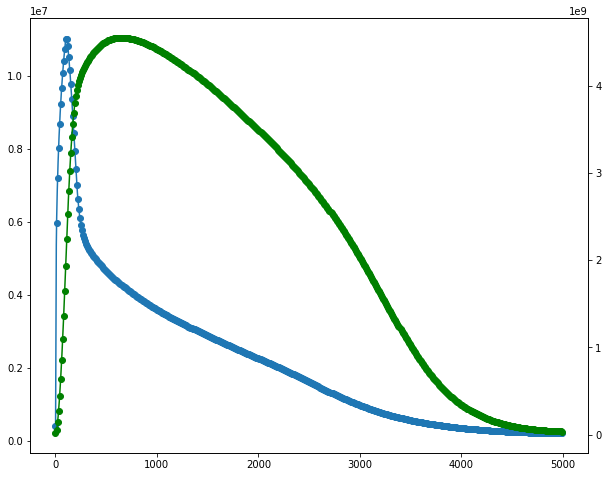

In [53]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.plot(time_ebtel,temperature_ebtel,marker='o',ls='-',markevery=100)
ax2 = ax.twinx()
ax2.plot(time_ebtel,density_ebtel,marker='o',ls='-',color='g',markevery=100)
#ax.set_xlim([0,50])
#ax2.set_ylim([0,200])

Run the IonPopSolver code

In [47]:
np.savetxt('ebtel_test.ips.input',np.vstack([time_ebtel,temperature_ebtel,density_ebtel]).T,
           header='{}'.format(time_ebtel.shape[0]),comments='',fmt='%f\t%e\t%e')

In [48]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run \
-Z 26 -f 1 -t 27 \
-I ebtel_test.ips.input \
-O ebtel_test.ips.output \
-r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

0%|         |100%
  |||||||||||

The process took 9.000000 seconds to run.


In [49]:
tmp = np.loadtxt('ebtel_test.ips.output')
time_ebtel_ips = tmp[:,0]
y_ebtel_ips = tmp[:,4:]

Run the implicit solver

In [54]:
y_implicit_ebtel = nei_implicit(time_ebtel,temperature_ebtel,density_ebtel,'Fe',temperature_grid)

And compare

(500, 5000)

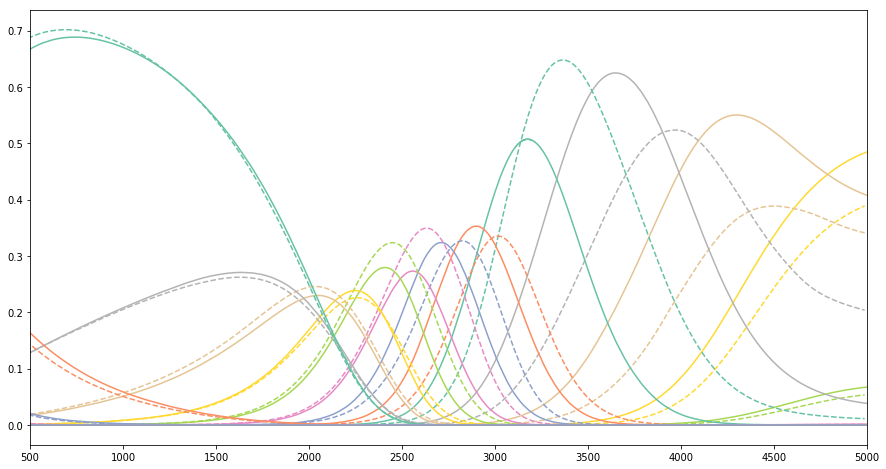

In [55]:
plt.figure(figsize=(15,8))
colors = sns.color_palette('Set2',n_colors=y_implicit_ebtel.shape[1])
for i in range(y_implicit_ebtel.shape[1]):
    plt.plot(time_ebtel,y_implicit_ebtel[:,i],ls='-',color=colors[i])
    plt.plot(time_ebtel_ips,y_ebtel_ips[:,i],ls='--',color=colors[i])
#plt.xscale('log')
plt.xlim([500,5000])

## Sandbox

In [ ]:
el = fiasco.Element('iron',temperature_grid)

In [ ]:
ioneq_fiasco = el.ionization_equilibrium()

In [ ]:
plt.figure(figsize=(15,8))
colors = sns.color_palette('Set2',n_colors=ioneq_ips.shape[1])
for i in range(ioneq_ips.shape[1]):
    plt.plot(10.**(temperature_grid_ips),ioneq_ips[:,i],color=colors[i]);
    #plt.plot(temperature_grid,ioneq_fiasco[:,i],ls='-',color=colors[i]);
for i,ion in enumerate(el):
    plt.plot(temperature_grid,ion.ioneq,ls=':',color=colors[i])
plt.xscale('log')